# Creating an Isochrone Map of High Schools and Transit Stops Within Walking Distance

In [203]:
#importing libraries for coding
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import contextily as ctx
import folium

In [204]:
latlon = [37.721420, -122.440305]
network_type = 'walk' # this defines the network
trip_times = [5, 10, 15] #in minutes
meters_per_minute = 75 # travel distance per minute

In [205]:
# download the street network
G = ox.graph_from_point(latlon, network_type=network_type, dist = 2000)

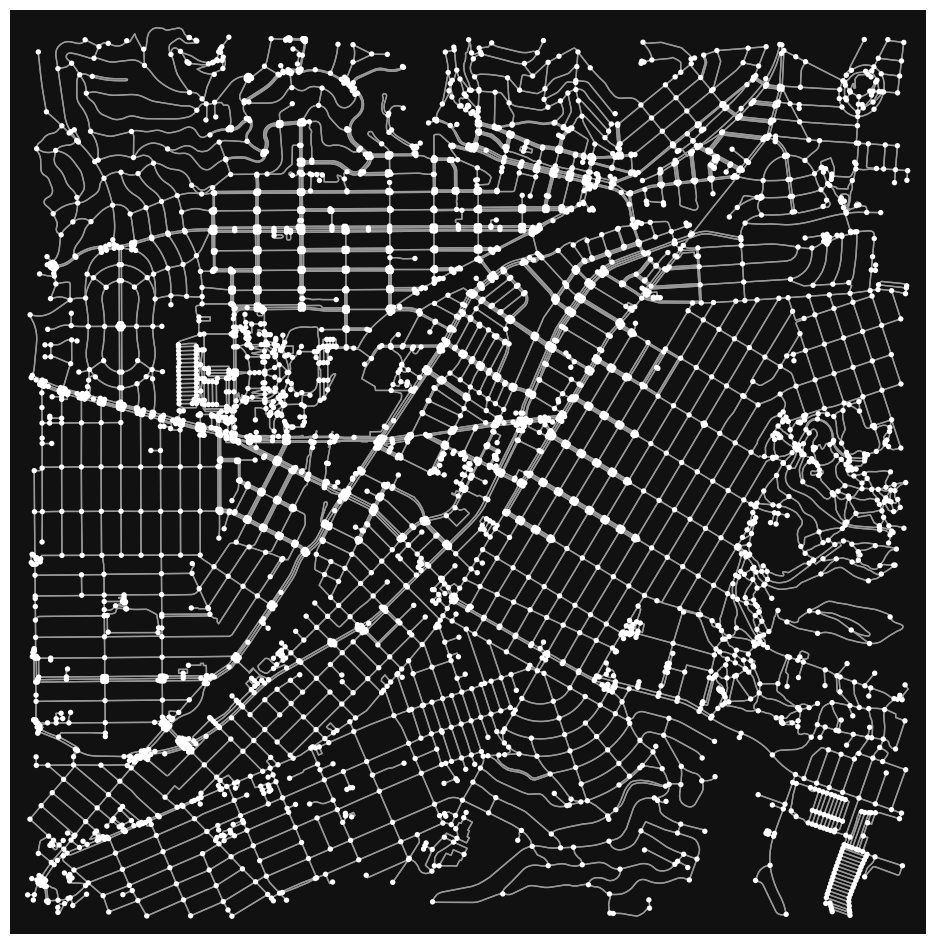

In [206]:
fig, ax = ox.plot_graph(G,figsize=(12,12))

In [207]:
#projecting to Web Mercator
G = ox.project_graph(G, to_crs='epsg:3857')

In [208]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [209]:
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-13632521.58400393
4537623.469173612
-13627462.358050257
4542676.972611059


In [210]:
# calculate the centroid
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

-13629991.971027095
4540150.220892336


In [211]:
center_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x)

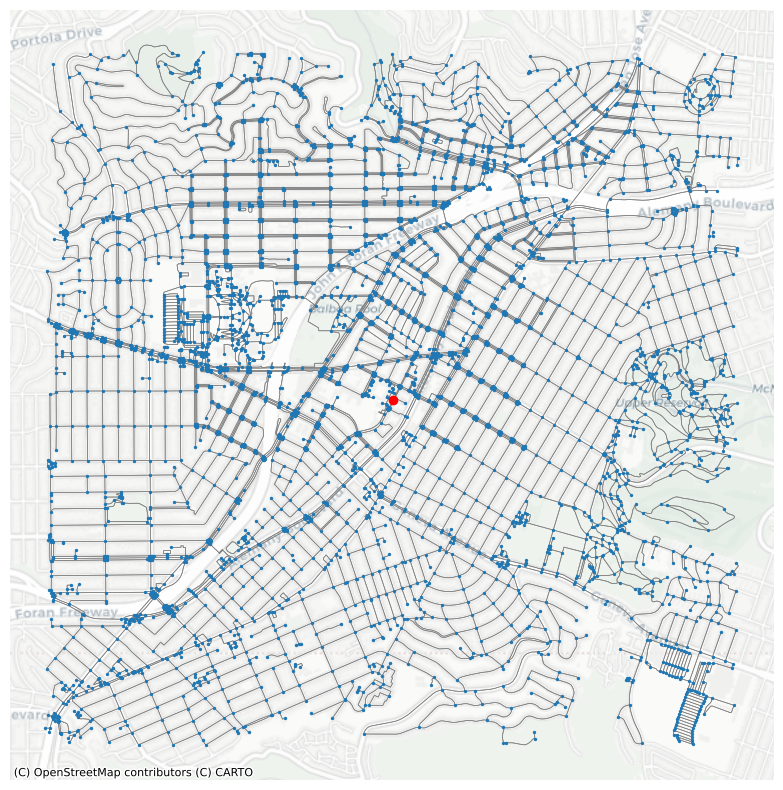

In [212]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gray', 
               zorder=10)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=2, 
               zorder=20)

# add the center node in red also to ax
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

In [213]:
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

In [214]:
gdf_edges[['osmid','name','highway','length','walk_time']].sample(10)

,,,osmid,name,highway,length,walk_time
u,v,key,,,,,
11781535929,11781535928,0,1268492044,NaN,footway,5.793691,0.077249
9894143898,9894143896,0,619535680,NaN,footway,2.247023,0.029960
11793162766,11793173970,0,8919208,Brazil Avenue,residential,66.786391,0.890485
5442256683,11788053510,0,"[286356674, 397107430]",Alemany Boulevard,primary,90.083955,1.201119
4257884837,1711296837,0,8917777,Cloud Circle,service,40.899372,0.545325
4295220610,4295220491,0,430247830,NaN,footway,243.800315,3.250671
1712533725,1712533777,0,159152673,NaN,footway,64.177045,0.855694
65297214,65305318,0,159149972,Hazelwood Avenue,residential,73.543602,0.980581
65287147,11788053520,0,8915753,Norton Street,residential,3.803041,0.050707


In [215]:
cmap = 'RdYlGn'

In [216]:
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap=cmap, 
                                start=0)
                               # return_hex=True)

In [217]:
time_color = list(zip(trip_times, iso_colors))
time_color

[(5, '#a50026'), (10, '#feffbe'), (15, '#006837')]

In [218]:
time_color.reverse()

In [219]:
for time, color in list(time_color):

    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node, radius=time,distance='time')

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' minutes ' + color)
    
    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = time
        gdf_nodes.loc[node,'color'] = color

There are 558 nodes within 15 minutes #006837
There are 203 nodes within 10 minutes #feffbe
There are 46 nodes within 5 minutes #a50026


In [220]:
gdf_nodes['color'].fillna('#cccccc', inplace=True)

/tmp/ipykernel_624/2599711709.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf_nodes['color'].fillna('#cccccc', inplace=True)


<Axes: >

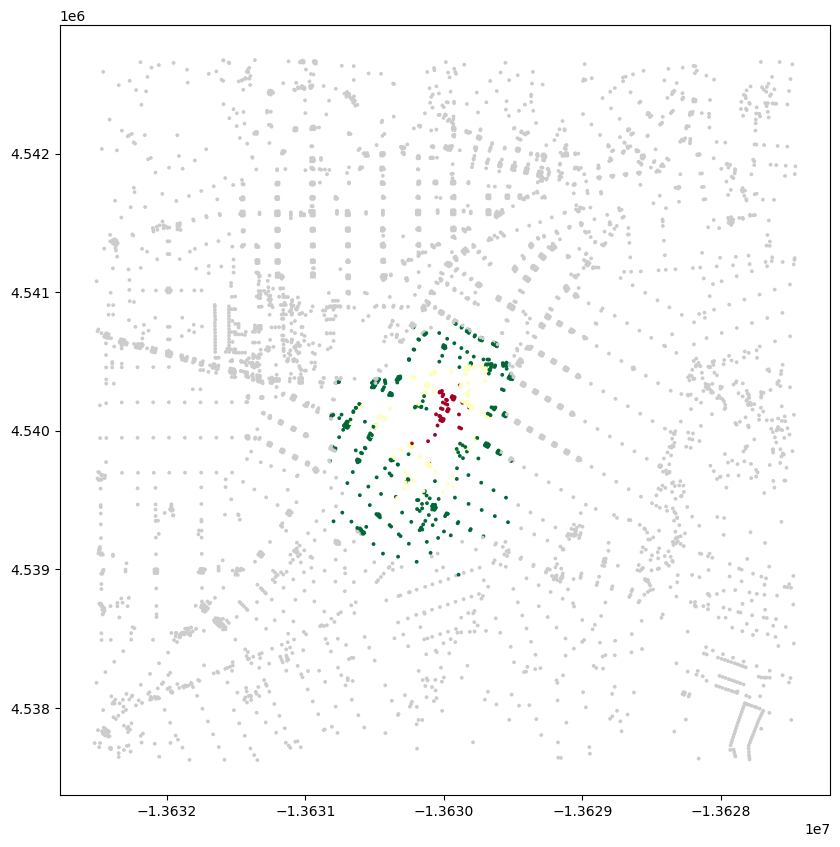

In [221]:
gdf_nodes.plot(figsize=(10,10),
               color=gdf_nodes['color'],
               markersize=3,
               )

In [222]:
gdf_5 = gdf_nodes[gdf_nodes['time']==5]

/tmp/ipykernel_624/1564010702.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_5.unary_union.convex_hull


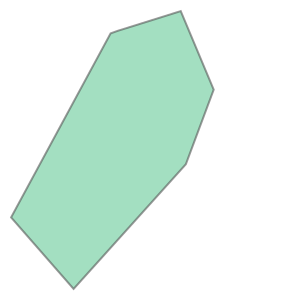

In [223]:
gdf_5.unary_union.convex_hull

In [224]:
isochrones = gdf_nodes.dissolve(by = "time")
isochrones

,geometry,y,x,street_count,highway,railway,color
time,,,,,,,
5.0,"MULTIPOINT ((-13630231.152 4539909.453), (-136...",4.540329e+06,-1.362989e+07,3,crossing,None,#a50026
10.0,"MULTIPOINT ((-13630675.283 4540055.715), (-136...",4.539560e+06,-1.363001e+07,3,traffic_signals,None,#feffbe
15.0,"MULTIPOINT ((-13630821.502 4539783.669), (-136...",4.538962e+06,-1.362989e+07,3,crossing,crossing,#006837


In [225]:
isochrones = isochrones.convex_hull.reset_index(name='geometry')
isochrones

,time,geometry
0,5.0,"POLYGON ((-13630104.059 4539764.037, -13630231..."
1,10.0,"POLYGON ((-13630338.709 4539515.936, -13630675..."
2,15.0,"POLYGON ((-13629894.021 4538962.001, -13630439..."


In [226]:
isochrones.sort_values(by='time', ascending=False,inplace=True)

In [227]:
iso_colors = ['#f7fcb9', '#addd8e', '#31a354']

<Axes: >

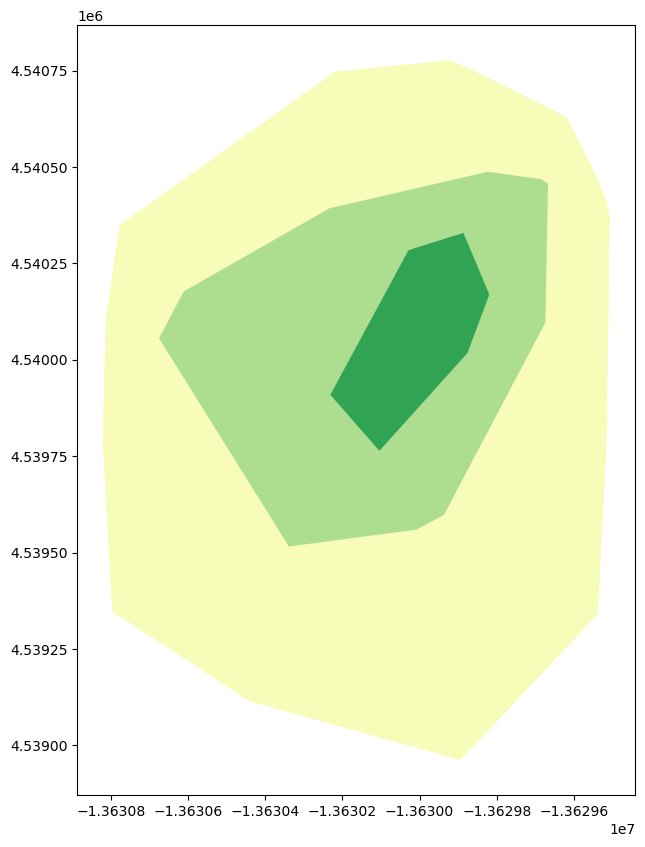

In [228]:
isochrones.plot(figsize=(10,10),alpha=1,color=iso_colors, legend=True)

In [229]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

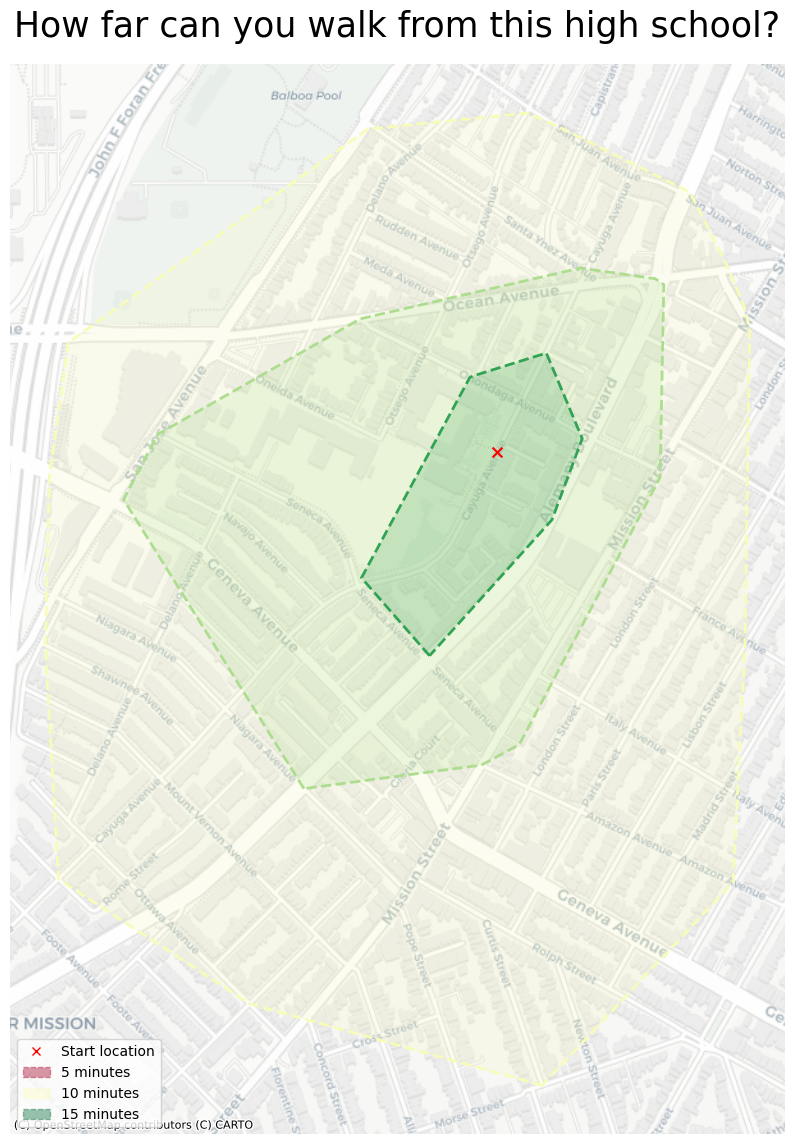

In [230]:
fig, ax = plt.subplots(figsize=(10,15))

# add the isochrone boundary
isochrones.boundary.plot(
    ax=ax,
    alpha=1,
    linestyle='--',
    color=iso_colors,
    lw=2
    ) 

# add the isochrones
isochrones.plot(
    ax=ax, 
    alpha=0.2, 
    categorical=True, # even though it is numeric, treat it as categorical
    color=iso_colors,
    )

# add the center node in red
gdf_nodes.loc[[center_node]].plot(
    ax=ax,
    color='r',
    marker='x',
    markersize=50
    )

# build custom legend
legend_elements = [
    # add the center node to the legend
    Line2D([0], [0], marker='x', color='red', linestyle='',label='Start location', markersize=6),
    ]

# sort back to small time to large time
# time_color.sort(reverse=False)
time_color.reverse()

# loop through the list of time/colors and add each to the legend
for time,color in list(time_color):
    legend_item = Patch(facecolor=color, edgecolor=color, linestyle='--',linewidth=1,label=str(time)+' minutes',alpha=0.4)
    legend_elements.append(legend_item)

# add the legend
ax.legend(handles=legend_elements,loc='lower left') # location options: upper/center/lower and left/center/right

# add a title
ax.set_title('How far can you walk from this high school?',fontsize=25,pad=20)

# hide the axis
ax.axis('off')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
